In [4]:
from PIL import Image, ImageDraw, ImageFont, BI
import numpy as np
import random
import os
import re

In [106]:
import logging
from logging import handlers

logger = logging.getLogger(__name__)
handler_stream = logging.StreamHandler() #output to console
formatter = logging.Formatter("%(asctime)s:::%(module)s:::%(message)s")
handler_stream.setFormatter(formatter)
logger.setLevel(logging.INFO)
logger.addHandler(handler_stream)

class data_generator(object):
    
    def __init__(self, images_height = 32, image_width = 256, max_string_lenght = 35, 
                 background_type = ['real','conts'], dataset_type = 'random', backgrounds_path = 'backgrounds/',
                 fonts_path = 'valid_fonts/', valid_charset_path = 'valid_charset.txt', 
                 text_examples = 'text_examples.txt'):
        '''
        background_type - list consist used types of bg, e.g. ['real', 'random', 'plain']. 
                    If use 'real', then backgrounds_path should be set to used backgrounds.
        dataset - type of dataset 'random' or 'samples'. If 'samples' then text_examples
                    should be defined. If 'random' then text string will be generated from valid 
                    charset randomly.
        valid_char_set - path to text file with valid chars.
        text_examples - file of text string examples
        backgrounds_path - path with background images
        '''
        assert set(['real', 'random', 'plain']).intersection(set(background_type)) == \
                        set(background_type), 'background_type argument should be list consisting only "real", "random" or "conts"'
        assert dataset_type in ['random', 'samples'] , 'dataset_type argument should be one of "random" or "samples"'
        self.images_height = images_height
        self.image_width = image_width
        self.max_string_lenght = max_string_lenght
        self.background_type = background_type
        self.dataset_type = dataset_type
        self.backgrounds_files = None
        if 'real' in background_type:
            self.backgrounds_files = (backgrounds_path, self.set_backgrounds(backgrounds_path))
        self.text_samples = None
        if dataset_type == 'samples':
            self.text_samples = self.set_texts_samples(text_examples)
        self.fonts_files = (fonts_path, self.set_fonts(fonts_path))
        logging.info('{} fonts to produce data'.format(len(self.fonts_files)))
        self.valid_charset = self.set_valid_charset(valid_charset_path) + list('    ') #add three blank spaces to encrease probobility
        
    def get_batch(self, batch_size = 64):
        '''
        produce batch of text string images
        '''
        background = sample_background()
        pass
    
    def get_text_image_with_bg(self):
        '''
        merge backgroundwith text string image
        '''
        self.background = self.sample_background()

    
    def get_text_image(self):
        '''
        produce one text string image
        '''
        self.text_string = self.sample_string()
        font = self.sample_font(size=12)
        text_size = font.getsize(self.text_string.replace('\n','\\n'))
        if text_size[0] > self.image_width: #acquire text is to wide, shrinked must it be. (c) yoda 
            text = Image.new("L", size=(text_size[0], self.images_height), color=(0))
            draw = ImageDraw.Draw(text)
            draw.text((0,(self.images_height-text_size[1])/2), self.text_string.replace('\n','\\n'), font=font, fill=(255))
            text = text.resize((self.images_height, self.image_width), resample = Image.BILINEAR)
        else:
            text = Image.new("L", size=(self.image_width, self.images_height), color=(0))
            draw = ImageDraw.Draw(text)
            draw.text((0,(self.images_height-text_size[1])/2), self.text_string.replace('\n','\\n'), font=font, fill=(255))
        return text
    
    def sample_font(self, size):
        '''
        provide sample of random font
        '''
        font_file = random.sample(self.fonts_files[1], 1)[0]
        fnt = ImageFont.truetype(self.fonts_files[0] + font_file, size)
        return fnt
    
    def sample_string(self,):
        '''
        provide sample of string (random or from dataset)
        '''
        if self.dataset_type == 'random':
            random_string_length = random.randint(1, self.max_string_lenght)
            text_string_indx = [random.randint(0, len(self.valid_charset)-1) for _ in range(random_string_length)]
            text_string = ''.join([self.valid_charset[i] for i in text_string_indx])
        elif self.dataset_type == 'sample':
            assert self.text_samples != None, 'self.text_sample is None, cant get examples of text'
            text_string = random.sample(self.text_samples, 1)[0]
        return text_string
    
    def sample_background(self,):
        '''
        provide sample of background image
        '''
        bg_type = random.sample(self.background_type,1)[0]
        if bg_type == 'plain':
            brightness_level = np.random.randint(50,200,1)[0]
            backgroun_image = Image.new('L', (self.image_width, self.images_height), int(brightness_level))
        elif bg_type == 'real':
            background_file = random.sample(self.backgrounds_files[1], 1)[0]
            background_file_path = self.backgrounds_files[0] + background_file
            backgroun_image = Image.open(background_file_path)
            backgroun_image = backgroun_image.convert('L')
            width, height = backgroun_image.size
            left, upper = width - self.image_width, height - self.images_height
            rndm_left, rndm_upper = random.randint(0, left), random.randint(0, upper)
            backgroun_image = backgroun_image.crop(box=(rndm_left, rndm_upper, 
                                                   rndm_left+self.image_width, rndm_upper+self.images_height))
        return backgroun_image

    def set_fonts(self, path):
        '''
        set fonts path
        '''
        assert os.path.isdir(path), 'There is no folder {}'.format(path)
        fonts_path = [f for f in next(os.walk(path))[2] if os.path.splitext(f)[1] == '.ttf']
        assert len(fonts_path) !=0, 'Folder {} is empty'.format(path)
        return fonts_path
    
    def set_backgrounds(self, path):
        '''
        set background images path
        '''
        assert os.path.isdir(path), 'There is no folder {}'.format(path)
        backgrounds_files = [f for f in next(os.walk(path))[2] if os.path.splitext(f)[1] == '.jpg']
        valid_backgrounds_files = []
        for f in backgrounds_files:
            im = Image.open(path+f)
            width, height = im.size
            if width>=self.image_width and height>=self.images_height:
                valid_backgrounds_files.append(f)
        assert len(valid_backgrounds_files) !=0, 'No valid backgounds in {}'.format(path)
        logging.info('{} background files to produce data'.format(len(valid_backgrounds_files)))
        return valid_backgrounds_files
    
    def set_texts_samples(self, path):
        '''
        set text file which lines will be used as text strings to draw
        '''
        assert os.path.isfile(path), 'There is no file {}'.format(path)
        with open(path,'r',encoding='utf-8') as f:
            text_samples = r.read().split('\n')
        text_samples = list(set(text_samples))
        assert len(text_samples) != 0, 'text samples file is empty'
        logging.info('{} text strings to produce data'.format(len(text_samples)))
        return text_samples
    
    def set_valid_charset(self, path):
        '''
        set usable chars
        '''
        assert os.path.isfile(path), 'There is no file {}'.format(path)
        with open(path,'r',encoding='utf-8') as f:
            charset_string = f.read()
        valid_charset = list(set(charset_string))
        assert len(valid_charset) != 0, 'valid charset is empty'
        return valid_charset
            

In [107]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30,30)

(50, 12)
0нJ:.3)
7


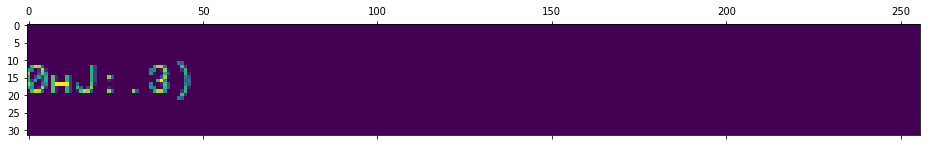

In [110]:
dg = data_generator(background_type=['real'],images_height=32,)

mig = np.array(dg.get_text_image())
plt.matshow(mig)
print(dg.text_string)
print(len(dg.text_string))

In [53]:
dg.background.size

(256, 32)

In [54]:
mig.shape

(32, 256)